----------------------------------------------------------------------

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader , random_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from torchvision.models import resnet18
import matplotlib.pyplot as plt

In [8]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [9]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
# train_dataset = torchvision.datasets.SVHN(root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
# test_dataset = torchvision.datasets.SVHN(root='./data', train=False, download=True, transform=transform)

# Split train dataset into training and validation
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
model = CNN().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 5

In [22]:
import numpy as np
import torch.nn.functional as F

def compute_entropy(probabilities):
    return -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)

total_validation_loss = 0.0
average_confidence = 0
confidences = []
entropies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch} loss : {running_loss / len(train_loader)}')

    # Validation phase
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    total_confidence = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            softmax_output = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(softmax_output, dim=1)

            confidences.extend(confidence.cpu().numpy())

            entropy = compute_entropy(softmax_output)
            entropies.extend(entropy.cpu().numpy())

            total_confidence += confidence.sum().item()
            total_samples += labels.size(0)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    average_confidence += total_confidence / total_samples
    # total_validation_loss += validation_loss / len(validation_loader)

    print(f'Epoch {epoch + 1}, Validation Loss: {validation_loss / len(validation_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Average Confidence: {average_confidence:.4f}')

average_confidence_threshold = average_confidence / num_epochs
print(f'Average confidence threshold: {average_confidence_threshold:.4f}')

print('Finished Training')


Epoch 0 loss : 1.424730528831482
Epoch 1, Validation Loss: 1.1056, Accuracy: 60.11%, Average Confidence: 0.5870
Epoch 1 loss : 0.9892294533729553
Epoch 2, Validation Loss: 0.9130, Accuracy: 68.05%, Average Confidence: 1.2510
Epoch 2 loss : 0.7998412702083587
Epoch 3, Validation Loss: 0.8195, Accuracy: 70.99%, Average Confidence: 1.9647
Epoch 3 loss : 0.6639934288024902
Epoch 4, Validation Loss: 0.7780, Accuracy: 73.23%, Average Confidence: 2.7354
Epoch 4 loss : 0.5578153473854065
Epoch 5, Validation Loss: 0.7472, Accuracy: 74.61%, Average Confidence: 3.5271
Average confidence threshold: 0.7054
Finished Training


# General Precision

In [27]:
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f'Number of samples: {len(all_labels)}')
count_label_5 = all_labels.count(5)
print(f'Number of samples with label 5: {count_label_5}')
precision_general = precision_score(all_labels, all_predictions, average=None)  # دقت برای هر کلاس
recall_general = recall_score(all_labels, all_predictions, average=None)
for i in range (len (precision_general)):
     print(f'Precision for class {i} on easy samples: {precision_general[i]}')
     print(f'Recall for class {i} on easy samples: {recall_general[i]}')









Number of samples: 10000
Number of samples with label 5: 1000
Precision for class 0 on easy samples: 0.7983193277310925
Recall for class 0 on easy samples: 0.76
Precision for class 1 on easy samples: 0.8173431734317343
Recall for class 1 on easy samples: 0.886
Precision for class 2 on easy samples: 0.6466602129719264
Recall for class 2 on easy samples: 0.668
Precision for class 3 on easy samples: 0.5889121338912134
Recall for class 3 on easy samples: 0.563
Precision for class 4 on easy samples: 0.7458379578246392
Recall for class 4 on easy samples: 0.672
Precision for class 5 on easy samples: 0.6752688172043011
Recall for class 5 on easy samples: 0.628
Precision for class 6 on easy samples: 0.7568493150684932
Recall for class 6 on easy samples: 0.884
Precision for class 7 on easy samples: 0.8093264248704664
Recall for class 7 on easy samples: 0.781
Precision for class 8 on easy samples: 0.8439073514602216
Recall for class 8 on easy samples: 0.838
Precision for class 9 on easy samples: 

# Shanon Entropy precentile

Threshold (percentile 100): 2.2316689491271973
Number of easy samples: 10000
Number of samples with label 5: 1000
Precision for class 0 on easy samples: 0.7983193277310925
Recall for class 0 on easy samples: 0.76
Precision for class 1 on easy samples: 0.8173431734317343
Recall for class 1 on easy samples: 0.886
Precision for class 2 on easy samples: 0.6466602129719264
Recall for class 2 on easy samples: 0.668
Precision for class 3 on easy samples: 0.5889121338912134
Recall for class 3 on easy samples: 0.563
Precision for class 4 on easy samples: 0.7458379578246392
Recall for class 4 on easy samples: 0.672
Precision for class 5 on easy samples: 0.6752688172043011
Recall for class 5 on easy samples: 0.628
Precision for class 6 on easy samples: 0.7568493150684932
Recall for class 6 on easy samples: 0.884
Precision for class 7 on easy samples: 0.8093264248704664
Recall for class 7 on easy samples: 0.781
Precision for class 8 on easy samples: 0.8439073514602216
Recall for class 8 on easy sa

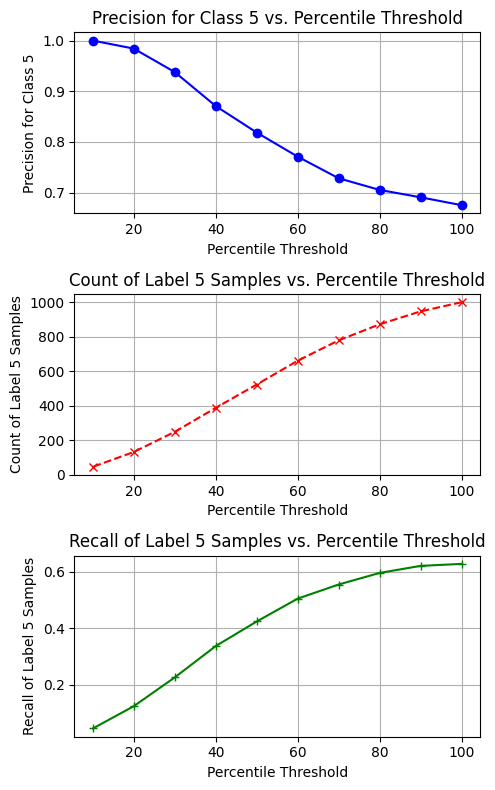

In [66]:
model.eval()
entropy_output = []
all_predictions = []
all_labels = []


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)  
        entropy = compute_entropy(probabilities)
        max_probs, predicted = torch.max(probabilities, dim=1)

        # ذخیره نتایج
        entropy_output.extend(entropy.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


entropy_output = np.array(entropy_output)
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# لیست آستانه‌ها از 10 تا 90 درصد
percentiles = range(100, 0, -10)

precision_class_5 = []
label_5_counts = []
recall_class_5 = []


for percentile in percentiles:
    threshold = np.percentile(entropies, percentile)
    selected_indices = entropy_output <= threshold
    recall_easy = []
    # محاسبه دقت روی داده‌های انتخاب شده
    selected_predictions = all_predictions[selected_indices]
    selected_labels = all_labels[selected_indices]

    if len(selected_labels) > 0:
        precision_easy = precision_score(selected_labels, selected_predictions, average=None)  # دقت برای هر کلاس
        precision_class_5.append(precision_easy[5])  # دقت کلاس پنجم

        for class_idx in range(len(precision_easy)):
            true_positives = np.sum((selected_predictions == class_idx) & (selected_labels == class_idx))
            total_actual = np.sum(all_labels == class_idx)
            recall = true_positives / total_actual if total_actual > 0 else 0
            recall_easy.append(recall)
            if class_idx == 5:
              recall_class_5.append(recall_easy[5])


        count_label_5 = np.sum(selected_labels == 5)
        label_5_counts.append(count_label_5)
        print(f'Threshold (percentile {percentile}): {threshold}')
        print(f'Number of easy samples: {len(selected_labels)}')
        print(f'Number of samples with label 5: {count_label_5}')
        for i in range(len(precision_easy)):
            print(f'Precision for class {i} on easy samples: {precision_easy[i]}')
            print(f'Recall for class {i} on easy samples: {recall_easy[i]}')




    else:
        precision_class_5.append(0)
        recall_class_5.append(0)
        label_5_counts.append(0)

        print(f'Threshold (percentile {percentile}): {threshold} - No easy samples found')

# رسم نمودار دقت کلاس پنجم و تعداد نمونه‌های با برچسب 5
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 8))

# Plot precision for class 5
ax1.plot(percentiles, precision_class_5, marker='o', linestyle='-', color='b')
ax1.set_xlabel('Percentile Threshold')
ax1.set_ylabel('Precision for Class 5')
ax1.set_title('Precision for Class 5 vs. Percentile Threshold')
ax1.grid(True)

# Plot count of label 5 samples
ax2.plot(percentiles, label_5_counts, marker='x', linestyle='--', color='r')
ax2.set_xlabel('Percentile Threshold')
ax2.set_ylabel('Count of Label 5 Samples')
ax2.set_title('Count of Label 5 Samples vs. Percentile Threshold')
ax2.grid(True)

ax3.plot(percentiles, recall_class_5, marker='+', linestyle='-', color='g')
ax3.set_xlabel('Percentile Threshold')
ax3.set_ylabel('Recall of Label 5 Samples')
ax3.set_title('Recall of Label 5 Samples vs. Percentile Threshold')
ax3.grid(True)



plt.tight_layout()
plt.show()

# Calculate threshold of probabilitis

Threshold (percentile 0): 0.14787070453166962
Number of easy samples: 10000
Number of samples with label 5: 1000
Precision for class 0 on easy samples: 0.7983193277310925
Recall for class 0 on easy samples: 0.76
Precision for class 1 on easy samples: 0.8173431734317343
Recall for class 1 on easy samples: 0.886
Precision for class 2 on easy samples: 0.6466602129719264
Recall for class 2 on easy samples: 0.668
Precision for class 3 on easy samples: 0.5889121338912134
Recall for class 3 on easy samples: 0.563
Precision for class 4 on easy samples: 0.7458379578246392
Recall for class 4 on easy samples: 0.672
Precision for class 5 on easy samples: 0.6752688172043011
Recall for class 5 on easy samples: 0.628
Precision for class 6 on easy samples: 0.7568493150684932
Recall for class 6 on easy samples: 0.884
Precision for class 7 on easy samples: 0.8093264248704664
Recall for class 7 on easy samples: 0.781
Precision for class 8 on easy samples: 0.8439073514602216
Recall for class 8 on easy sam

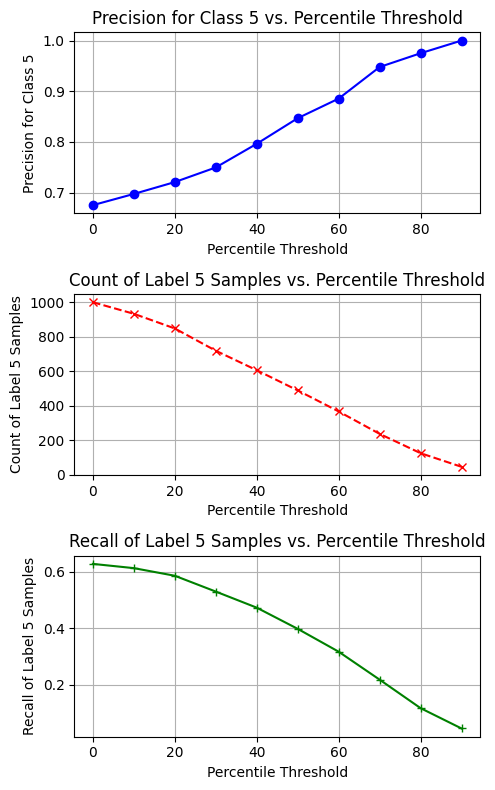

In [45]:
model.eval()
softmax_probs = []
all_predictions = []
all_labels = []


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)  # محاسبه احتمال‌های Softmax
        max_probs, predicted = torch.max(probabilities, dim=1)

        # ذخیره نتایج
        softmax_probs.extend(max_probs.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# تبدیل به آرایه‌های NumPy
softmax_probs = np.array(softmax_probs)
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# لیست آستانه‌ها از 10 تا 90 درصد
percentiles = range(0, 100, 10)
precision_class_5 = []
label_5_counts = []
recall_class_5 = []


for percentile in percentiles:
    threshold = np.percentile(confidences, percentile)
    selected_indices = softmax_probs >= threshold
    recall_easy = []
    # محاسبه دقت روی داده‌های انتخاب شده
    selected_predictions = all_predictions[selected_indices]
    selected_labels = all_labels[selected_indices]

    if len(selected_labels) > 0:
        precision_easy = precision_score(selected_labels, selected_predictions, average=None)  # دقت برای هر کلاس
        precision_class_5.append(precision_easy[5])  # دقت کلاس پنجم

        for class_idx in range(len(precision_easy)):
            true_positives = np.sum((selected_predictions == class_idx) & (selected_labels == class_idx))
            total_actual = np.sum(all_labels == class_idx)
            recall = true_positives / total_actual if total_actual > 0 else 0
            recall_easy.append(recall)
            if class_idx == 5:
              recall_class_5.append(recall_easy[5])


        count_label_5 = np.sum(selected_labels == 5)
        label_5_counts.append(count_label_5)
        print(f'Threshold (percentile {percentile}): {threshold}')
        print(f'Number of easy samples: {len(selected_labels)}')
        print(f'Number of samples with label 5: {count_label_5}')
        for i in range(len(precision_easy)):
            print(f'Precision for class {i} on easy samples: {precision_easy[i]}')
            print(f'Recall for class {i} on easy samples: {recall_easy[i]}')




    else:
        precision_class_5.append(0)
        recall_class_5.append(0)
        label_5_counts.append(0)

        print(f'Threshold (percentile {percentile}): {threshold} - No easy samples found')

# رسم نمودار دقت کلاس پنجم و تعداد نمونه‌های با برچسب 5
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 8))

# Plot precision for class 5
ax1.plot(percentiles, precision_class_5, marker='o', linestyle='-', color='b')
ax1.set_xlabel('Percentile Threshold')
ax1.set_ylabel('Precision for Class 5')
ax1.set_title('Precision for Class 5 vs. Percentile Threshold')
ax1.grid(True)

# Plot count of label 5 samples
ax2.plot(percentiles, label_5_counts, marker='x', linestyle='--', color='r')
ax2.set_xlabel('Percentile Threshold')
ax2.set_ylabel('Count of Label 5 Samples')
ax2.set_title('Count of Label 5 Samples vs. Percentile Threshold')
ax2.grid(True)

ax3.plot(percentiles, recall_class_5, marker='+', linestyle='-', color='g')
ax3.set_xlabel('Percentile Threshold')
ax3.set_ylabel('Recall of Label 5 Samples')
ax3.set_title('Recall of Label 5 Samples vs. Percentile Threshold')
ax3.grid(True)



plt.tight_layout()
plt.show()